In [ ]:
"""
This code pulls heavily from the following existing repositories: 

https://github.com/willjobs/regulations-public-comments
https://github.com/jacobfeldgoise/regulations-comments-downloader
"""

In [1]:
# imports
import os
import requests
import json
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
import time

import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# import certifi
# import urllib3

# http = urllib3.PoolManager(
#     cert_reqs="CERT_REQUIRED",
#     ca_certs=certifi.where()
# )

api_key = os.getenv("REG_GOV_API_KEY")
if not api_key:
    raise ValueError("Regulations.gov API key not found in environment variables")


In [3]:
def get_document_ids(docket_id, api_key):
    docs_url = "https://api.regulations.gov/v4/documents?filter[docketId]={}&api_key={}".format(
        docket_id, api_key
    )
    data = json.loads(requests.get(docs_url).text)

    if ("error" in data) and (data["error"]["code"] == "OVER_RATE_LIMIT"):
        print(
            "["
            + str(datetime.datetime.now())
            + "] "
            + "You've exceeded your API limit! Wait an hour and try again. Don't worry, we saved your progress."
        )
        return None

    data = data["data"]
    doc_ids = []
    doc_links = []
    for i in range(len(data)):
        doc_ids.append(data[i]["attributes"]["objectId"])
        doc_links.append(data[i]["links"]["self"])

    print(
        "["
        + str(datetime.datetime.now())
        + "] "
        + "Retrieved {} documents for docket {}".format(len(doc_ids), docket_id)
    )
    return doc_ids, doc_links

In [4]:
def _is_duplicated_on_server(response_json):
    """Used to determine whether a given response indicates a duplicate on the server. This is
    because there is a bug in the server: there are some commentIds, like NRCS-2009-0004-0003,
    which correspond to multiple actual comments! This function determines whether the
    returned JSON has an error indicating this issue

    Args:
        response_json (dict): JSON from request to API (usually, from get_request_json)

    Returns:
        bool: whether the response indicates a duplicate issue or not
    """
    return ('errors' in response_json.keys()) \
            and (response_json['errors'][0]['status'] == "500") \
            and (response_json['errors'][0]['detail'][:21] == "Incorrect result size")


In [5]:
def get_request_json(api_key, endpoint, params=None, print_remaining_requests=False,
                        wait_for_rate_limits=False, skip_duplicates=False):
    """Used to return the JSON associated with a request to the API

    Args:
        endpoint (str): URL of the API to access (e.g., https://api.regulations.gov/v4/documents)
        params (dict, optional): Parameters to specify to the endpoint request. Defaults to None.
            If we are querying the non-details endpoint, we also append the "page[size]" parameter 
            so that we always get the maximum page size of 250 elements per page.
        print_remaining_requests (bool, optional): Whether to print out the number of remaining
            requests this hour, based on the response headers. Defaults to False.
        wait_for_rate_limits (bool, optional): Determines whether to wait to re-try if we run out of
            requests in a given hour. Defaults to False.
        skip_duplicates (bool, optional): If a request returns multiple items when only 1 was expected,
            should we skip that request? Defaults to False.

    Returns:
        dict: JSON-ified request response
    """

    # Our API key has a rate limit of 1,000 requests/hour. If we hit that limit, we can
    # retry every WAIT_MINUTES minutes (more frequently than once an hour, in case our request limit
    # is updated sooner). We will sleep for POLL_SECONDS seconds at a time to see if we've been
    # interrupted. Otherwise we'd have to wait a while before getting interrupted. We could do this
    # with threads, but that gets more complicated than it needs to be.
    STATUS_CODE_OVER_RATE_LIMIT = 429
    WAIT_MINUTES = 20  # time between attempts to get a response
    POLL_SECONDS = 10  # run time.sleep() for this long, so we can check if we've been interrupted
    
    params = params if params is not None else {}
    
    # whether we are querying the search endpoint (e.g., /documents) or the "details" endpoint
    if (endpoint.split("/")[-1] in ["dockets", "documents", "comments"]):
        params = {**params, "page[size]": 250}  # always get max page size

    # Rather than do requests.get(), use this approach to (attempt to) gracefully handle noisy connections to the server
    # We sometimes get SSL errors (unexpected EOF or ECONNRESET), so this should hopefully help us retry.
    session = requests.Session()
    session.mount('https', HTTPAdapter(max_retries=4))

    def poll_for_response(api_key, else_func):
        r = session.get(endpoint,
                        headers={'X-Api-Key': api_key},
                        params=params,
                        verify=True)

        if r.status_code == 200:
            # SUCCESS! Return the JSON of the request
            num_requests_left = int(r.headers['X-RateLimit-Remaining'])
            if print_remaining_requests or \
                (num_requests_left < 10) or \
                (num_requests_left <= 100 and num_requests_left % 10 == 0) or \
                (num_requests_left % 100 == 0 and num_requests_left < 1000):
                print(f"(Requests left: {r.headers['X-RateLimit-Remaining']})")

            return [True, r.json()]
        else:
            if r.status_code == STATUS_CODE_OVER_RATE_LIMIT and wait_for_rate_limits:
                else_func()
            elif _is_duplicated_on_server(r.json()) and skip_duplicates:
                print("****Duplicate entries on server. Skipping.")
                print(r.json()['errors'][0]['detail'])
            else:  # some other kind of error
                print([r, r.status_code])
                print(r.json())
                r.raise_for_status()

        return [False, r.json()]

    def wait_for_requests():
        the_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f'{the_time}: Hit rate limits. Waiting {WAIT_MINUTES} minutes to try again', flush=True)
        # We ran out of requests. Wait for WAIT_MINUTES minutes, but poll every POLL_SECONDS seconds for interruptions
        for i in range(int(WAIT_MINUTES * 60 / POLL_SECONDS)):
            time.sleep(POLL_SECONDS)

    for _ in range(1, int(60 / WAIT_MINUTES) + 3):
        success, r_json = poll_for_response(api_key, wait_for_requests)

        if success or (_is_duplicated_on_server(r_json) and skip_duplicates):
            return r_json

    print(r_json)
    raise RuntimeError(f"Unrecoverable error; {r_json}")

In [6]:
def get_items_count(data_type, params):
    """Gets the number of items returned by a request in the totalElements attribute.

    Args:
        data_type (str): One of "dockets", "documents", or "comments".
        params (dict): Parameters to specify to the endpoint request for the query. See details
            on available parameters at https://open.gsa.gov/api/regulationsgov/.

    Returns:
        int: Number of items returned by request
    """
    # make sure the data_type is plural
    data_type = data_type if data_type[-1:] == "s" else data_type + "s"

    r_items = get_request_json(api_key, f'https://api.regulations.gov/v4/{data_type}', params=params)
    totalElements = r_items['meta']['totalElements']
    return totalElements

In [22]:
get_items_count('dockets',{})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


246837

In [23]:
get_items_count('comments',{})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


21568414

In [ ]:
f'https://api.regulations.gov/v4/documents?filter[postedDate][ge]=2024-01-01&filter[postedDate][le]=2024-04-04&api_key={api_key}'

In [30]:
get_items_count("dockets", params={"filter[lastModifiedDate][ge]": "2024-01-01 00:00:00",
                                    "filter[lastModifiedDate][le]": "2024-04-03 23:59:59",})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


8317

In [24]:
get_items_count("documents", params={"filter[postedDate][ge]": "2024-01-01",
                                    "filter[postedDate][le]": "2024-04-03",})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


23497

In [28]:
get_items_count("comments", params={"filter[postedDate][ge]": "2024-01-01",
                                    "filter[postedDate][le]": "2024-04-03",})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


336494

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureReque

(Requests left: 900)


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureReque

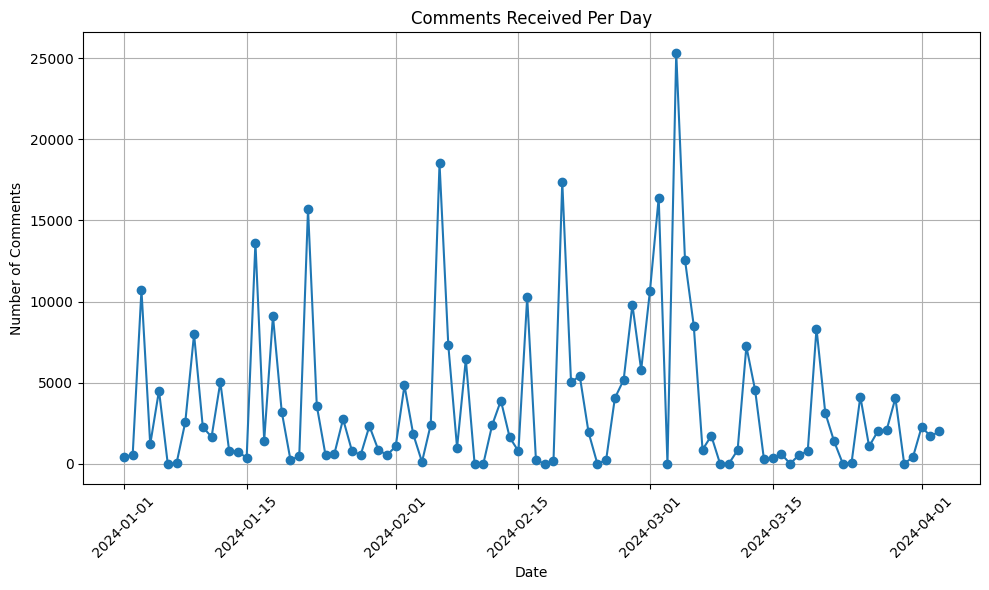

In [40]:
def get_comments_per_day(start_date, end_date):
    # Initialize an empty dictionary to store counts per day
    counts_per_day = {}

    # Convert start and end dates to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    # Iterate over each day between start_date and end_date
    current_date = start_date
    while current_date <= end_date:
        # Format the current date as required for the API call
        formatted_date = current_date.strftime("%Y-%m-%d")

        # Call get_items_count function to get count for the current date
        count = get_items_count("comments", {"filter[postedDate][eq]": formatted_date})

        # Store the count in the dictionary
        counts_per_day[current_date] = count

        # Move to the next day
        current_date += timedelta(days=1)

    return counts_per_day

counts_per_day = get_comments_per_day("2024-01-01", "2024-04-03")


In [ ]:
def make_comments_per_day(counts_per_day)
    # Plot the counts_per_day
    plt.figure(figsize=(10, 6))
    plt.plot(list(counts_per_day.keys()), list(counts_per_day.values()), marker='o')
    plt.xlabel('Date')
    plt.ylabel('Number of Comments')
    plt.title('Comments Received Per Day')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

make_comments_per_day(counts_per_day)

In [42]:
new_dockets = get_request_json(api_key, 'https://api.regulations.gov/v4/dockets', {"filter[lastModifiedDate][ge]": "2024-04-01 00:00:00",
                                    "filter[lastModifiedDate][le]": "2024-04-03 23:59:59",})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [47]:
new_dockets['data'][2]

{'id': 'FDA-2024-H-1140',
 'type': 'dockets',
 'attributes': {'docketType': 'Nonrulemaking',
  'lastModifiedDate': '2024-04-01T07:57:44Z',
  'highlightedContent': None,
  'agencyId': 'FDA',
  'title': 'DAB Civil Money Penalty; DSW Enterprises, Inc. d/b/a Natural Bridge / Exxon; CLOSED 3/28/2024',
  'objectId': '0b00006486468f10'},
 'links': {'self': 'https://api.regulations.gov/v4/dockets/FDA-2024-H-1140'}}

In [8]:
new_documents = get_request_json(api_key, 'https://api.regulations.gov/v4/documents', {"filter[postedDate][ge]": "2024-04-01",
                                                                                    "filter[postedDate][le]": "2024-04-03",})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [53]:
new_documents['data']

[{'id': 'FAA-2022-1463-0076',
  'type': 'documents',
  'attributes': {'documentType': 'Rule',
   'lastModifiedDate': '2024-04-01T14:38:18Z',
   'highlightedContent': '',
   'frDocNum': '2024-06644',
   'withdrawn': False,
   'agencyId': 'FAA',
   'commentEndDate': None,
   'title': 'Airman Certification Standards and Practical Test Standards for Airmen; Incorporation by Reference',
   'postedDate': '2024-04-01T04:00:00Z',
   'docketId': 'FAA-2022-1463',
   'subtype': 'Final Rule',
   'commentStartDate': '2024-04-01T04:00:00Z',
   'openForComment': False,
   'objectId': '09000064864b1699'},
  'links': {'self': 'https://api.regulations.gov/v4/documents/FAA-2022-1463-0076'}},
 {'id': 'OSHA-2009-0028-0011',
  'type': 'documents',
  'attributes': {'documentType': 'Supporting & Related Material',
   'lastModifiedDate': '2024-04-01T13:33:54Z',
   'highlightedContent': '',
   'frDocNum': None,
   'withdrawn': False,
   'agencyId': 'OSHA',
   'commentEndDate': None,
   'title': 'Supporting Stat

In [26]:
new_documents['meta']['lastPage']

False

In [80]:
new_documents['data'][49]

{'id': 'FSIS-2022-0014-0001',
 'type': 'documents',
 'attributes': {'documentType': 'Rule',
  'lastModifiedDate': '2024-04-02T11:36:46Z',
  'highlightedContent': '',
  'frDocNum': '2024-06837',
  'withdrawn': False,
  'agencyId': 'FSIS',
  'commentEndDate': '2024-06-01T03:59:59Z',
  'title': 'Guideline for Controlling Retained Water in Raw Meat and Poultry',
  'postedDate': '2024-04-01T04:00:00Z',
  'docketId': 'FSIS-2022-0014',
  'subtype': None,
  'commentStartDate': '2024-04-01T04:00:00Z',
  'openForComment': True,
  'objectId': '09000064864b182d'},
 'links': {'self': 'https://api.regulations.gov/v4/documents/FSIS-2022-0014-0001'}}

In [85]:
new_documents['data']

[{'id': 'FAA-2022-1463-0076',
  'type': 'documents',
  'attributes': {'documentType': 'Rule',
   'lastModifiedDate': '2024-04-01T14:38:18Z',
   'highlightedContent': '',
   'frDocNum': '2024-06644',
   'withdrawn': False,
   'agencyId': 'FAA',
   'commentEndDate': None,
   'title': 'Airman Certification Standards and Practical Test Standards for Airmen; Incorporation by Reference',
   'postedDate': '2024-04-01T04:00:00Z',
   'docketId': 'FAA-2022-1463',
   'subtype': 'Final Rule',
   'commentStartDate': '2024-04-01T04:00:00Z',
   'openForComment': False,
   'objectId': '09000064864b1699'},
  'links': {'self': 'https://api.regulations.gov/v4/documents/FAA-2022-1463-0076'}},
 {'id': 'OSHA-2009-0028-0011',
  'type': 'documents',
  'attributes': {'documentType': 'Supporting & Related Material',
   'lastModifiedDate': '2024-04-01T13:33:54Z',
   'highlightedContent': '',
   'frDocNum': None,
   'withdrawn': False,
   'agencyId': 'OSHA',
   'commentEndDate': None,
   'title': 'Supporting Stat

In [11]:
# The problem is that this is limited to only 250 records -- need to go 
# onto the next page and repeat calls

len(new_documents['data'])

250

In [ ]:
doc_data = get_request_json(api_key, 'https://api.regulations.gov/v4/documents', {"filter[postedDate][ge]": "2024-04-01",
                                                                                    "filter[postedDate][le]": "2024-04-03",
                                                                                    "page[number]": "2"})

In [27]:
def get_multiple_pages_documents_from_api(api_key, params):
    doc_data = None

    # we can get at most 20 pages in an api call -- pages start at #1
    for i in range(1,21):

        # add page number to the params
        params["page[number]"] = str(i)
        #print(f'{params=}')

        if doc_data is not None:
            next_page_data = get_request_json(api_key, 'https://api.regulations.gov/v4/documents', params)
            doc_data += next_page_data['data']
        else:
            next_page_data = get_request_json(api_key, 'https://api.regulations.gov/v4/documents', params)
            doc_data = next_page_data['data']

        # stop if we're on the last page
        if next_page_data['meta']['lastPage']:
            break

    return doc_data

In [32]:
doc_data = get_multiple_pages_documents_from_api(api_key, {"filter[postedDate][ge]": "2024-01-01", "filter[postedDate][le]": "2024-04-03"}) 

params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '1'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '2'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '3'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '4'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '5'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '6'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '7'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '8'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '9'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '10'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '11'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '12'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '13'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '14'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '15'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '16'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '17'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '18'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '19'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


params={'filter[postedDate][ge]': '2024-01-01', 'filter[postedDate][le]': '2024-04-03', 'page[number]': '20'}


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [46]:
def get_docs_available_for_comment(doc_data):

    # Initialize a defaultdict to store counts of documents per day
    documents_per_day = defaultdict(int)

    # Iterate over each document in the data
    for document in doc_data:
        attributes = document.get('attributes', {})

        if attributes['openForComment']:
            posted_date_str = attributes.get('postedDate')
            
            # Parse the posted date string to a datetime object
            posted_date = datetime.strptime(posted_date_str, '%Y-%m-%dT%H:%M:%SZ').date()
            
            # Increment the count for the corresponding day
            documents_per_day[posted_date] += 1

    # Convert defaultdict to a sorted list of tuples for plotting
    sorted_documents_per_day = sorted(documents_per_day.items())

    # Unpack sorted_documents_per_day into separate lists for plotting
    dates, counts = zip(*sorted_documents_per_day)

    return dates, counts

dates, counts = get_docs_available_for_comment(doc_data)


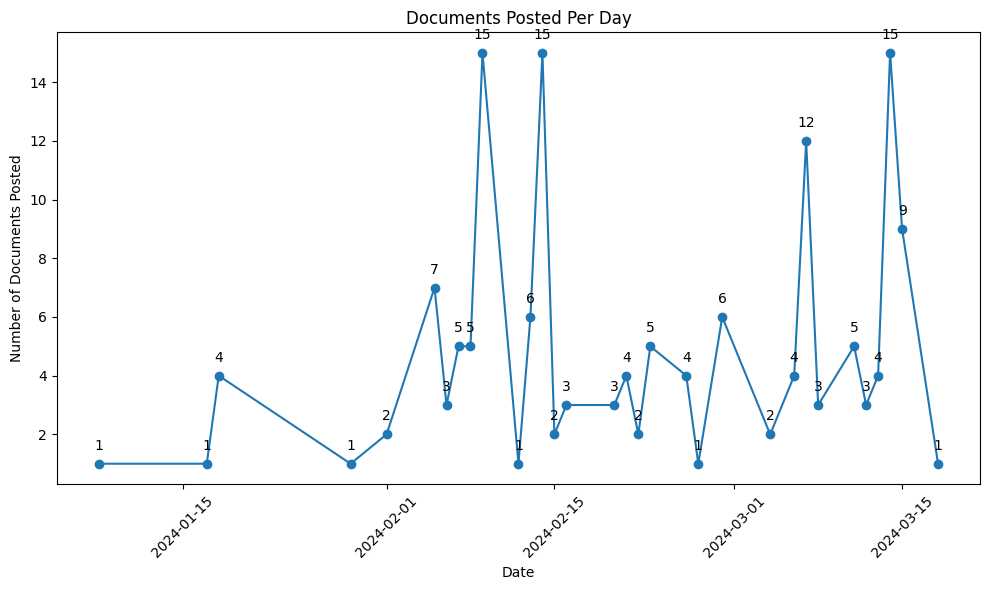

In [47]:
def make_doc_count_graph(dates, counts):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates, counts, marker='o')
    plt.xlabel('Date')
    plt.ylabel('Number of Documents Posted')
    plt.title('Documents Posted Per Day')
    plt.xticks(rotation=45)
    
    # Add annotations for each point
    for i, count in enumerate(counts):
        plt.annotate(str(count), (dates[i], count), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()

make_doc_count_graph(dates, counts)

Notes: 

Commenting is conducted on documents, not dockets. Helpful intro: https://www.regulations.gov/learn

Just because there is a 'commentStartDate' doesn't meet the document is actually available for commenting

Need to consider requiring a certificate requirement for out API calls: https://urllib3.readthedocs.io/en/latest/user-guide.html#ssl. This would get rid of the warning we get from every API call


Also, inconsistency between API and the url:

From the API:

{'id': 'FAA-2022-1463-0076',
  'type': 'documents',
  'attributes': {'documentType': 'Rule',
   'lastModifiedDate': '2024-04-01T14:38:18Z',
   'highlightedContent': '',
   'frDocNum': '2024-06644',
   'withdrawn': False,
   'agencyId': 'FAA',
   'commentEndDate': None,
   'title': 'Airman Certification Standards and Practical Test Standards for Airmen; Incorporation by Reference',
   'postedDate': '2024-04-01T04:00:00Z',
   'docketId': 'FAA-2022-1463',
   'subtype': 'Final Rule',
   'commentStartDate': '2024-04-01T04:00:00Z',
   'openForComment': False,
   'objectId': '09000064864b1699'},
  'links': {'self': 'https://api.regulations.gov/v4/documents/FAA-2022-1463-0076'}},

The website:

https://www.regulations.gov/document/FAA-2022-1463-0076

As of 4.4.2024, that document is available to comment on.

We can 


In [36]:
## How to access the actual materials? 

# get_items_count("documents", params={"filter[lastModifiedDate][ge]": "2024-01-01 00:00:00",
#                                     "filter[lastModifiedDate][le]": "2024-04-03 23:59:59",})

url = f'https://api.regulations.gov/v4/documents/FAA-2022-1463-0076?api_key={api_key}'

data = json.loads(requests.get(url).text)

In [41]:
print(data['data'])

{'id': 'FAA-2022-1463-0076', 'type': 'documents', 'links': {'self': 'https://api.regulations.gov/v4/documents/FAA-2022-1463-0076'}, 'attributes': {'additionalRins': None, 'allowLateComments': True, 'authorDate': None, 'authors': None, 'cfrPart': '14 CFR Parts 61, 63, and 65', 'commentEndDate': None, 'commentStartDate': '2024-04-01T04:00:00Z', 'effectiveDate': None, 'exhibitLocation': None, 'exhibitType': None, 'frDocNum': '2024-06644', 'frVolNum': None, 'implementationDate': None, 'media': None, 'ombApproval': None, 'paperLength': 0, 'paperWidth': 0, 'regWriterInstruction': None, 'sourceCitation': None, 'startEndPage': '22482 - 22520', 'subject': None, 'topics': ['Aircraft', 'Airmen', 'Aviation Safety', 'Incorporation by Reference', 'Recreation and Recreation Areas', 'Reporting and Recordkeeping Requirements', 'Teachers', 'Navigation (Air)', 'Air Traffic Controllers', 'Airports'], 'address1': None, 'address2': None, 'agencyId': 'FAA', 'city': None, 'category': None, 'comment': None, 'c

In [60]:
def pull_reg_gov_data(api_key, data_type, params=None, print_remaining_requests=False,
                      wait_for_rate_limits=False, skip_duplicates=False):
    """Used to return the JSON associated with a request to the API

    draws heavily from here: https://github.com/willjobs/regulations-public-comments/blob/master/comments_downloader.py

    Args:
        data_type (str): 'dockets', 'documents', or 'comments' -- what kind of data we want back from the API
        params (dict, optional): Parameters to specify to the endpoint request. Defaults to None.
            If we are querying the non-details endpoint, we also append the "page[size]" parameter 
            so that we always get the maximum page size of 250 elements per page.
        print_remaining_requests (bool, optional): Whether to print out the number of remaining
            requests this hour, based on the response headers. Defaults to False.
        wait_for_rate_limits (bool, optional): Determines whether to wait to re-try if we run out of
            requests in a given hour. Defaults to False.
        skip_duplicates (bool, optional): If a request returns multiple items when only 1 was expected,
            should we skip that request? Defaults to False.

    Returns:
        dict: JSON-ified request response
    """
    # generate the right API request
    api_url = "https://api.regulations.gov/v4/"
    endpoint = f'{api_url}{data_type}'

    # Our API key has a rate limit of 1,000 requests/hour. If we hit that limit, we can
    # retry every WAIT_MINUTES minutes (more frequently than once an hour, in case our request limit
    # is updated sooner). We will sleep for POLL_SECONDS seconds at a time to see if we've been
    # interrupted. Otherwise we'd have to wait a while before getting interrupted. We could do this
    # with threads, but that gets more complicated than it needs to be.
    STATUS_CODE_OVER_RATE_LIMIT = 429
    WAIT_MINUTES = 20  # time between attempts to get a response
    POLL_SECONDS = 10  # run time.sleep() for this long, so we can check if we've been interrupted
    
    params = params if params is not None else {}
    
    # whether we are querying the search endpoint (e.g., /documents) or the "details" endpoint
    if (endpoint.split("/")[-1] in ["dockets", "documents", "comments"]):
        params = {**params, "page[size]": 250}  # always get max page size

    # Rather than do requests.get(), use this approach to (attempt to) gracefully handle noisy connections to the server
    # We sometimes get SSL errors (unexpected EOF or ECONNRESET), so this should hopefully help us retry.
    session = requests.Session()
    session.mount('https', HTTPAdapter(max_retries=4))

    def poll_for_response(api_key, else_func):
        r = session.get(endpoint,
                        headers={'X-Api-Key': api_key},
                        params=params,
                        verify=False)

        if r.status_code == 200:
            # SUCCESS! Return the JSON of the request
            num_requests_left = int(r.headers['X-RateLimit-Remaining'])
            if print_remaining_requests or \
                (num_requests_left < 10) or \
                (num_requests_left <= 100 and num_requests_left % 10 == 0) or \
                (num_requests_left % 100 == 0 and num_requests_left < 1000):
                print(f"(Requests left: {r.headers['X-RateLimit-Remaining']})")

            return [True, r.json()]
        else:
            if r.status_code == STATUS_CODE_OVER_RATE_LIMIT and wait_for_rate_limits:
                else_func()
            elif _is_duplicated_on_server(r.json()) and skip_duplicates:
                print("****Duplicate entries on server. Skipping.")
                print(r.json()['errors'][0]['detail'])
            else:  # some other kind of error
                print([r, r.status_code])
                print(r.json())
                r.raise_for_status()

        return [False, r.json()]

    def wait_for_requests():
        the_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f'{the_time}: Hit rate limits. Waiting {WAIT_MINUTES} minutes to try again', flush=True)
        # We ran out of requests. Wait for WAIT_MINUTES minutes, but poll every POLL_SECONDS seconds for interruptions
        for i in range(int(WAIT_MINUTES * 60 / POLL_SECONDS)):
            time.sleep(POLL_SECONDS)
        
    doc_data = None  # Initialize doc_data to None
    for i in range(1, 21):  # Fetch up to 20 pages
        params["page[number]"] = str(i)  # Add page number to the params

        for _ in range(1, int(60 / WAIT_MINUTES) + 3):
            success, r_json = poll_for_response(api_key, wait_for_requests)

            if success or (_is_duplicated_on_server(r_json) and skip_duplicates):
                if doc_data is not None:
                    doc_data += r_json['data']
                else:
                    doc_data = r_json['data']

                # Break if it's the last page
                if r_json['meta']['lastPage']:
                    return doc_data

    print(r_json)
    raise RuntimeError(f"Unrecoverable error; {r_json}")


In [66]:
test_data = pull_reg_gov_data(api_key, 'documents', params={"filter[postedDate][ge]": "2024-01-01", "filter[postedDate][le]": "2024-04-03"})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[<Response [400]>, 400]
{'errors': [{'status': '400', 'title': 'Invalid filter field name: postedDate'}]}


HTTPError: 400 Client Error: Bad Request for url: https://api.regulations.gov/v4/dockets?filter%5BpostedDate%5D%5Bge%5D=2024-01-01&filter%5BpostedDate%5D%5Ble%5D=2024-04-03&page%5Bsize%5D=250&page%5Bnumber%5D=1

In [69]:
test_data = pull_reg_gov_data(api_key, 'dockets', params={"filter[lastModifiedDate][ge]": "2024-01-01 00:00:00", "filter[lastModifiedDate][le]": "2024-04-03 23:59:59"})

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureReque

(Requests left: 800)


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


(Requests left: 800)


/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureReque

In [70]:
len(test_data)

24000

In [72]:
test_data[-1]

{'id': 'FAA-2024-0757',
 'type': 'dockets',
 'attributes': {'docketType': 'Rulemaking',
  'lastModifiedDate': '2024-03-27T12:19:24Z',
  'highlightedContent': None,
  'agencyId': 'FAA',
  'title': 'MCAI-2023-01205-T; Airbus SAS Model A318; A319; Model A320; and Model A321 airplanes; cracking of the front spar vertical stringers and the horizontal floor beam on a certain frame (FR).',
  'objectId': '0b0000648646bd93'},
 'links': {'self': 'https://api.regulations.gov/v4/dockets/FAA-2024-0757'}}

In [2]:
from access_api_data import pull_reg_gov_data, api_date_format_params

In [3]:
param_dates = api_date_format_params('documents', '2024-04-03', '2024-04-07')

In [4]:
param_dates

{'filter[postedDate][ge]': '2024-04-03',
 'filter[postedDate][le]': '2024-04-07'}

In [9]:
new_docs = pull_reg_gov_data(api_key, 'documents', '2024-04-03', '2024-04-07')

/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.regulations.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/andrewdunn/Desktop/Classes/UChicago/2024 - Spring Quarter/Software Engineering for Civic Tech/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureReque

In [10]:
len(new_docs)

3823

In [12]:
new_docs[0]

{'id': 'EERE-2019-BT-STD-0018-0187',
 'type': 'documents',
 'attributes': {'documentType': 'Supporting & Related Material',
  'lastModifiedDate': '2024-04-04T14:27:46Z',
  'highlightedContent': '',
  'frDocNum': None,
  'withdrawn': False,
  'agencyId': 'EERE',
  'commentEndDate': None,
  'title': 'Life-Cycle Cost (LCC) Medium-voltage Dry-Type Equipment Class 8 (EC8) - Representative Unit 12 (RU12) Spreadsheet for Distribution Transformers Final Rule',
  'postedDate': '2024-04-04T04:00:00Z',
  'docketId': 'EERE-2019-BT-STD-0018',
  'subtype': 'Spreadsheets',
  'commentStartDate': None,
  'openForComment': False,
  'objectId': '09000064864b93a8'},
 'links': {'self': 'https://api.regulations.gov/v4/documents/EERE-2019-BT-STD-0018-0187'}}

In [15]:
counter = 0
for doc in new_docs:
    if doc['attributes']['openForComment']:
        counter += 1

print(counter)

383


In [3]:
new_comments = pull_reg_gov_data(api_key, 'comments', '2024-04-03', '2024-04-07')

(Requests left: 900)


In [5]:
len(new_comments)

24000